In [1]:
# !rm -rf /kaggle/working/handwriting-generator-model
# !git clone https://github.com/Shambu-K/handwriting-generator-model.git
# !pip install fastdtw
# %cd /kaggle/working/handwriting-generator-model/Code/STR_model

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [3]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx} | Loss: {loss.item()}')
            
    return loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, data_path, plot=True):
    train_losses = []
    for epoch in range(num_epochs):
        if plot: visualize_progress(model, device, data_path)
        print('=====================================================================\n')
        loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        train_losses.append(loss)
        scheduler.step()
        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 100
batch_size = 32 # Archibald it is 32
checkpoint_interval = 1
learning_rate = 0.0001
lr_decay = 0.99

print('Using device:', device)

In [5]:
# Load data
# root_dir = '/kaggle/input/iam-dataset-online/Resized_Dataset/Train'
root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 1370/1370 [00:26<00:00, 51.13it/s]


In [6]:
# Model
model = STR_Model_Longer_1024().to(device)
set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss(sos_weight=20)

Image id: 6365


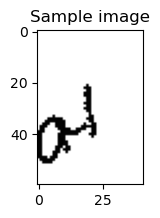

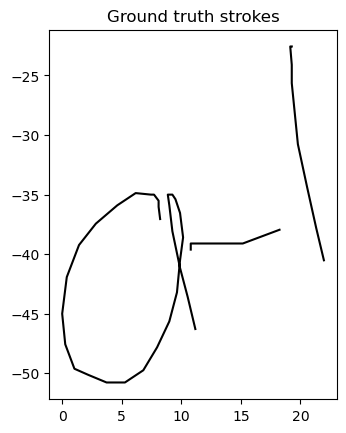

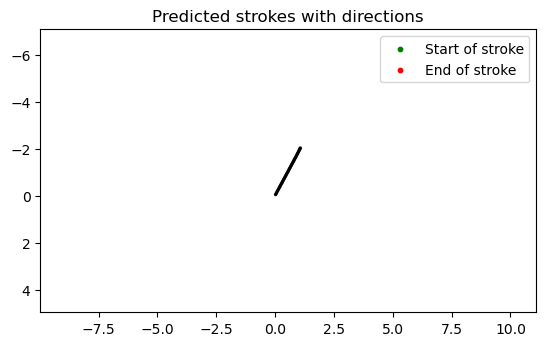

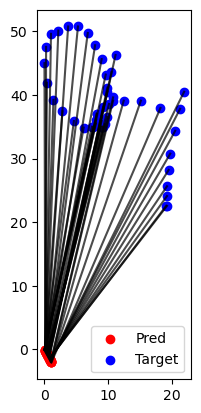

Epoch 1:   0%|          | 0/1370 [00:00<?, ?it/s]

   Batch: 0 | Loss: 1172.1921628189407
   Batch: 100 | Loss: 632.8669029081034
   Batch: 200 | Loss: 711.3224189618821
   Batch: 300 | Loss: 624.8755092753916
   Batch: 400 | Loss: 740.5223739282812
   Batch: 500 | Loss: 789.8684881093967
   Batch: 600 | Loss: 927.2390446714169
   Batch: 700 | Loss: 912.6481741253866
   Batch: 800 | Loss: 955.1989956541489
   Batch: 900 | Loss: 917.4614428326887
   Batch: 1000 | Loss: 1116.9271210083916
   Batch: 1100 | Loss: 1135.6946575634577
   Batch: 1200 | Loss: 1467.0737720777206


OutOfMemoryError: CUDA out of memory. Tried to allocate 206.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 190.81 MiB is free. Including non-PyTorch memory, this process has 3.54 GiB memory in use. Process 4407 has 37.47 MiB memory in use. Of the allocated memory 3.18 GiB is allocated by PyTorch, and 270.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, root_dir, plot=True)